In [3]:
from src.rl.env import NeuralEnv
from src.nn_env.model import TStransformer
from src.rl.rewards import RewardSender

import torch

# torch device state
print("torch device avaliable : ", torch.cuda.is_available())
print("torch current device : ", torch.cuda.current_device())
print("torch device num : ", torch.cuda.device_count())

# torch cuda initialize and clear cache
torch.cuda.init()
torch.cuda.empty_cache()

# device allocation
if(torch.cuda.device_count() >= 1):
    device = "cuda:{}".format(str(3))
else:
    device = 'cpu'

# 0D parameters
cols_0D = [
    '\\q0', '\\q95', '\\ipmhd', '\\kappa', 
    '\\tritop', '\\tribot','\\betap','\\betan',
    '\\li', '\\WTOT_DLM03'
]

# else diagnostics
cols_diag = [
    '\\ne_inter01', '\\ne_tci01', '\\ne_tci02', '\\ne_tci03', '\\ne_tci04', '\\ne_tci05',
]

# control value / parameter
cols_control = [
    '\\nb11_pnb','\\nb12_pnb','\\nb13_pnb',
    '\\RC01', '\\RC02', '\\RC03',
    '\\VCM01', '\\VCM02', '\\VCM03',
    '\\EC2_PWR', '\\EC3_PWR', 
    '\\ECSEC2TZRTN', '\\ECSEC3TZRTN',
    '\\LV01'
]

# predictor
model = TStransformer(
    n_features = len(cols_0D + cols_control), 
    feature_dims = 128, 
    max_len = 21, 
    n_layers = 4, 
    n_heads = 8, 
    dim_feedforward = 512, 
    dropout = 0.25, 
    mlp_dim = 64, 
    pred_len = 1,
    output_dim = len(cols_0D)
)

model.to(device)
model.load_state_dict(torch.load("./weights/TStransformer_best.pt"))

# reward 
targets_dict = {
    "\\betap" : 3.0,
    "\\betan" : 4.0,
    "\\q95" : 4.0,
    "\\q0" : 1.0
}

reward_sender = RewardSender(targets_dict, total_cols = cols_0D + cols_control)

env = NeuralEnv(predictor=model, device = device, reward_sender = reward_sender, seq_len = 21, pred_len = 3)

torch device avaliable :  True
torch current device :  0
torch device num :  4


In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler

df = pd.read_csv("./dataset/KSTAR_Disruption_ts_data_extend.csv").reset_index()
df_disruption = pd.read_csv("./dataset/KSTAR_Disruption_Shot_List.csv", encoding='euc-kr').reset_index()

# nan interpolation
df.interpolate(method = 'linear', limit_direction = 'forward')

# columns for use
ts_cols = cols_0D + cols_control

# float type
for col in ts_cols:
    df[col] = df[col].astype(np.float32)
    
df[cols_control] = df[cols_control].fillna(0)

df[cols_0D] = df[cols_0D].fillna(method = 'ffill')

scaler = RobustScaler()
df[ts_cols] = scaler.fit_transform(df[ts_cols].values)

df_shot = df[df.shot == 18156]
df_shot.head()

,index,time,shot,\q0,\q95,\ipmhd,\kappa,\tritop,\tribot,\betap,...,\TS_EDGE7:EDGE7_NE,\TS_EDGE8:EDGE8_NE,\TS_EDGE9:EDGE9_NE,\TS_EDGE10:EDGE10_NE,\TS_EDGE11:EDGE11_NE,\TS_EDGE12:EDGE12_NE,\TS_EDGE13:EDGE13_NE,\TS_EDGE14:EDGE14_NE,\TS_EDGE15:EDGE15_NE,frame_idx
248209,248209,0.000000,18156,226.400101,0.734357,-6.459929,0.542748,4.746996,-8.604465,-6.479645,...,7.390264e+21,1.103687e+22,3.163104e+21,9.632385e+21,4.466228e+22,-7.062761e+22,1.051886e+21,-1.425331e+22,NaN,0
248210,248210,0.019048,18156,210.940140,0.799791,-6.166759,0.237298,4.230034,-8.066546,-6.007341,...,6.806800e+21,1.015384e+22,2.914383e+21,8.915231e+21,4.114415e+22,-6.483132e+22,9.688003e+20,-1.304972e+22,NaN,4
248211,248211,0.038095,18156,196.218765,0.857500,-5.885434,-0.049120,3.742515,-7.557341,-5.561381,...,6.254798e+21,9.319105e+21,2.679008e+21,8.234592e+21,3.781529e+22,-5.935990e+22,8.902076e+20,-1.191517e+22,NaN,8
248212,248212,0.057143,18156,182.217560,0.907746,-5.615630,-0.317065,3.283589,-7.076055,-5.141022,...,5.733387e+21,8.531315e+21,2.456612e+21,7.589516e+21,3.467048e+22,-5.420402e+22,8.159826e+20,-1.084765e+22,NaN,12
248213,248213,0.076190,18156,168.918137,0.950792,-5.357021,-0.567092,2.852406,-6.621900,-4.745517,...,5.241699e+21,7.789115e+21,2.246830e+21,6.979049e+21,3.170452e+22,-4.935434e+22,7.460008e+20,-9.845148e+21,NaN,16


In [5]:
init_indices = df_shot[df_shot.time >= 1.0].index[0:21].values
init_state = df_shot[cols_0D].loc[init_indices].values
init_action = df_shot[cols_control].loc[init_indices].values

In [6]:
import torch

init_state = torch.from_numpy(init_state)
init_action = torch.from_numpy(init_action)
env.update_init_state(init_state, init_action)

In [7]:
# reset
state = env.reset()
print("state : ", state.size())
print(state)

state :  torch.Size([1, 21, 10])
tensor([[[-0.2462, -0.6201, -0.0873, -2.3022, -1.2656, -1.5584, -0.8653,
          -1.0152,  0.4383, -0.3671],
         [-0.2860, -0.6348, -0.1549, -2.3324, -1.3211, -1.5498, -0.8611,
          -1.0110,  0.5047, -0.3343],
         [-0.2708, -0.6272, -0.2179, -2.3373, -1.3560, -1.5381, -0.8533,
          -1.0041,  0.5128, -0.3052],
         [-0.2275, -0.5901, -0.2612, -2.3065, -1.3514, -1.5264, -0.8444,
          -0.9988,  0.4853, -0.2913],
         [-0.1689, -0.5323, -0.2762, -2.2455, -1.3111, -1.5114, -0.8340,
          -0.9927,  0.4337, -0.2929],
         [-0.1034, -0.4682, -0.2563, -2.1662, -1.2470, -1.4874, -0.8206,
          -0.9812,  0.3652, -0.3061],
         [-0.0464, -0.4123, -0.2050, -2.0836, -1.1743, -1.4548, -0.8057,
          -0.9646,  0.3013, -0.3271],
         [-0.0282, -0.3781, -0.1441, -2.0196, -1.1140, -1.4264, -0.7968,
          -0.9531,  0.2903, -0.3526],
         [-0.0774, -0.3777, -0.0968, -1.9949, -1.0864, -1.4150, -0.8013,
      

In [9]:
next_indices = df_shot[df_shot.time >= 1.0].index[21:42].values
next_action = df_shot[cols_control].loc[next_indices].values
next_action = torch.from_numpy(next_action)

print("next action : ", next_action.size())

next action :  torch.Size([21, 14])


In [10]:
next_state, reward, done, _ = env.step(next_action)

exp t : 0.019


In [11]:
print("next_state : ", next_state.size())
print("reward : ", reward)
print("done : ", done)

next_state :  torch.Size([1, 1, 10])
reward :  tensor(0.6329, device='cuda:3', grad_fn=<AddBackward0>)
done :  False


In [32]:
np.unique(df.shot)[-10:-1]

array([21680, 21681, 21682, 21683, 21706, 21730, 21731, 21735, 21747])

In [17]:
print("control values : {}".format(cols_control))
print('# of control values : {}'.format(len(cols_control)))

control values : ['\\nb11_pnb', '\\nb12_pnb', '\\nb13_pnb', '\\RC01', '\\RC02', '\\RC03', '\\VCM01', '\\VCM02', '\\VCM03', '\\EC2_PWR', '\\EC3_PWR', '\\ECSEC2TZRTN', '\\ECSEC3TZRTN', '\\LV01']
# of control values : 14


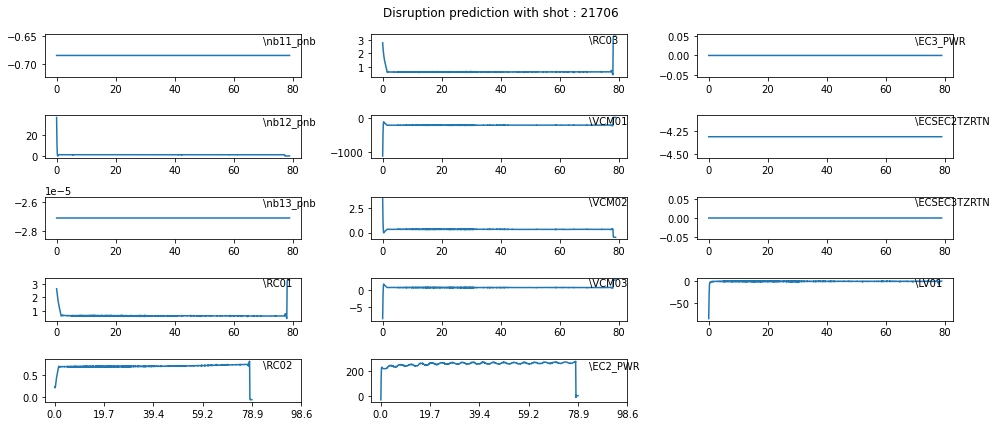

In [38]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

shot_num = 21706
t_control = df[df.shot == shot_num].time
df_control= df[df.shot == shot_num][cols_control]

fig = plt.figure(figsize = (14, 6))
fig.suptitle("Disruption prediction with shot : {}".format(shot_num))
gs = GridSpec(nrows = 5, ncols = 3)

quantile = [0, 0.25, 0.5, 0.75, 1.0, 1.25]
t_quantile = [q * max(t_control) for q in quantile]


idx_i = 0
idx_j = 0

for col in cols_control:
    ax = fig.add_subplot(gs[idx_i,idx_j])
    ax.plot(t_control, df_control[col], label = col)
    ax.text(0.85, 0.8, col, transform = ax.transAxes)
    
    if idx_i < 4:
        idx_i += 1
    else:
        idx_i = 0
        idx_j += 1
        ax.set_xticks(t_quantile)
        ax.set_xticklabels(["{:.1f}".format(t) for t in t_quantile])

fig.tight_layout()
plt.show()

In [ ]:
# test for nn-based surogated model
